In [62]:
from sklearn.datasets import fetch_lfw_people
from matplotlib import pyplot as plt
from matplotlib.pyplot import imread
import numpy as np
import seaborn as sns
import scipy

import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras import metrics # https://keras.io/metrics/ - ver a parte de custom metrics
from keras.callbacks import History 
from keras.utils.vis_utils import plot_model

import tensorflow as tf

In [70]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

### Funções minhas

In [63]:
# Adicionando ruído às imagens
def add_noise(sigma, bw_img):
    """Adiciona ruído a uma imagem em escala de cinza com valores entre 0 e 1"""
    sh = bw_img.shape
    noise = np.random.normal(0, sigma, sh)
    newgray = bw_img + noise
    return newgray

def plot_original_reconstructed(pred, conj, numero):
    figures, axes = plt.subplots(1, 3)
    axes[0].imshow(faces[numero].reshape(60, 44), cmap = 'gray')
    axes[0].set_title('Original image')
    axes[1].imshow(conj[numero].reshape(60, 44), cmap = 'gray')
    axes[1].set_title('Input (noisy image)')
    axes[2].imshow(pred[numero].reshape(60, 44), cmap = 'gray')
    axes[2].set_title('Reconstructed')

def plot_compare(idx, original, noisy, predicted):
    figures, axes = plt.subplots(1, 3)
    axes[0].imshow(original[idx].reshape(60, 44), cmap = 'gray')
    axes[0].set_title('Original image')
    axes[1].imshow(noisy[idx].reshape(60, 44), cmap = 'gray')
    axes[1].set_title('Input (noisy image)')
    axes[2].imshow(predicted[idx].reshape(60, 44), cmap = 'gray')
    axes[2].set_title('Reconstructed')

## Funcao custo customizada: SSIM

def ssim_loss(y_true, y_pred):
  return -tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

### Base de dados

In [64]:
### Base de dados

db = fetch_lfw_people()

faces = db['data']
total_imagens = len(faces)
faces_matrix = np.empty((total_imagens, 60, 44))

for i in range(total_imagens):
    faces_matrix[i] = faces[i].reshape(62, 47)[1:61, 1:45]

# Normalizando imagens
faces_matrix = faces_matrix/np.amax(faces_matrix)

# Adicionando ruído de sd = 0.05
del faces
faces = faces_matrix
noisyfaces = add_noise(0.05, faces)

## Separando em treino e teste

In [65]:
## Train and test split

train, test, noisytrain, noisytest = train_test_split(faces_matrix, noisyfaces, test_size = 0.2, random_state = 1)

noisytrain = noisytrain.reshape(-1, 60, 44, 1)
train = train.reshape(-1, 60, 44, 1)

noisytest = noisytest.reshape(-1, 60, 44, 1)
test = test.reshape(-1, 60, 44, 1)

### Escolhendo métricas que serão monitoradas

In [66]:
### Escolhendo métricas que serão monitoradas

# Funções custo e métricas podem ser utilizadas como métricas
metricas = [
            'mean_squared_error', 
            'mean_absolute_error',
            'binary_crossentropy', 
            'accuracy' 
            ] 

## Funcao custo customizada: SSIM

In [67]:
def ssim_loss(y_true, y_pred):
  return -tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

# Testando arquitetura 1:

In [7]:
def make_autoencoder():
  # encoding
  inputs = Input(shape=(60, 44, 1)) 
  x = Conv2D(filters = 1, kernel_size = (3, 3), activation = 'relu', padding = 'same')(inputs) 
  x = MaxPooling2D(pool_size = (2, 2), padding = 'same')(x)
  x = Conv2D(filters = 1, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x) 
  encoded = MaxPooling2D(padding = 'same')(x)

  # decoding
  x = UpSampling2D(size = (2, 2))(encoded)
  x = Conv2D(filters = 1, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')(x) 
  x = UpSampling2D(size = (2, 2))(x)
  decoded = Conv2D(filters = 1, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')(x) 

  # autoencoder compilation
  autoencoder = Model(inputs, decoded)
  autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = metricas)
  return autoencoder
autoencoder = make_autoencoder()
historia = History()

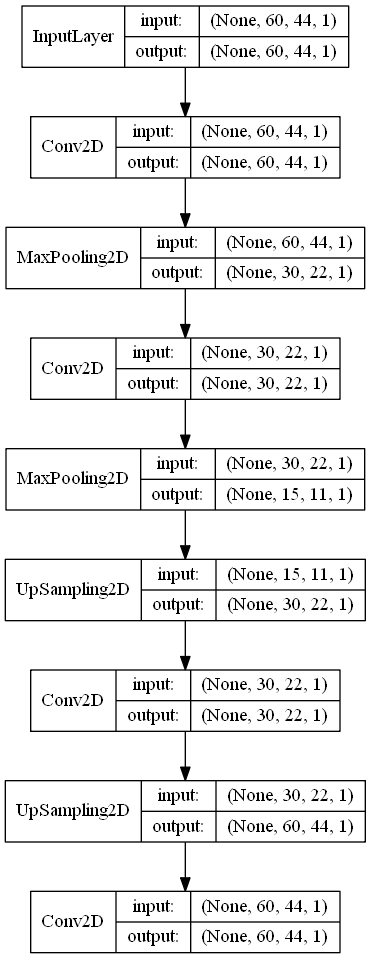

In [112]:
plot_model(autoencoder, show_shapes=True, show_layer_names=False)

In [113]:
autoencoder.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 60, 44, 1)         0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 60, 44, 1)         10        
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 30, 22, 1)         0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 30, 22, 1)         10        
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 15, 11, 1)         0         
_________________________________________________________________
up_sampling2d_28 (UpSampling (None, 30, 22, 1)         0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 30, 22, 1)         10 

In [114]:
autoencoder.fit(noisytrain, treino, epochs=40, batch_size=128, callbacks=[historia], validation_split = 0.1)

Train on 9527 samples, validate on 1059 samples
Epoch 1/40
9527/9527 [==============================] - 13s 1ms/step - loss: 0.0814 - mean_squared_error: 0.0814 - mean_absolute_error: 0.2347 - binary_crossentropy: 0.8049 - accuracy: 1.5944e-05 - val_loss: 0.0640 - val_mean_squared_error: 0.0640 - val_mean_absolute_error: 0.2028 - val_binary_crossentropy: 0.7615 - val_accuracy: 1.7884e-06
Epoch 2/40
9527/9527 [==============================] - 13s 1ms/step - loss: 0.0522 - mean_squared_error: 0.0522 - mean_absolute_error: 0.1801 - binary_crossentropy: 0.7347 - accuracy: 1.5944e-05 - val_loss: 0.0428 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1619 - val_binary_crossentropy: 0.7144 - val_accuracy: 1.7884e-06
Epoch 3/40
9527/9527 [==============================] - 13s 1ms/step - loss: 0.0381 - mean_squared_error: 0.0381 - mean_absolute_error: 0.1535 - binary_crossentropy: 0.7045 - accuracy: 1.6142e-05 - val_loss: 0.0348 - val_mean_squared_error: 0.0348 - val_mean_absolut

Epoch 25/40
9527/9527 [==============================] - 13s 1ms/step - loss: 0.0205 - mean_squared_error: 0.0205 - mean_absolute_error: 0.1077 - binary_crossentropy: 0.6687 - accuracy: 4.7950e-05 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1054 - val_binary_crossentropy: 0.6675 - val_accuracy: 5.0434e-05
Epoch 26/40
9527/9527 [==============================] - 13s 1ms/step - loss: 0.0192 - mean_squared_error: 0.0192 - mean_absolute_error: 0.1036 - binary_crossentropy: 0.6661 - accuracy: 4.8149e-05 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1013 - val_binary_crossentropy: 0.6650 - val_accuracy: 5.0791e-05
Epoch 27/40
9527/9527 [==============================] - 13s 1ms/step - loss: 0.0180 - mean_squared_error: 0.0180 - mean_absolute_error: 0.0997 - binary_crossentropy: 0.6636 - accuracy: 4.8149e-05 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.0974 - val_binary_crossentropy: 0.

### Predizendo

In [115]:
pred_train = autoencoder.predict(noisytrain) # in sample
pred_test = autoencoder.predict(noisytest) # out of sample

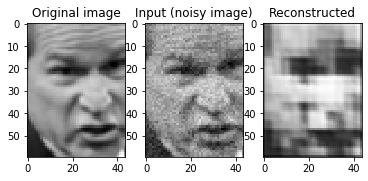

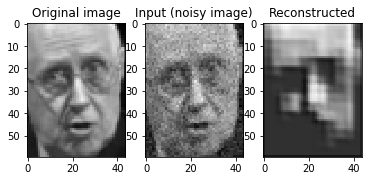

In [116]:
plot_compare(25, test, noisytest, pred_test) # out of sample prediction

plot_compare(15, train, noisytrain, pred_train) # in sample prediction - should be better

# Testando arquitetura 2:

In [68]:
def make_autoencoder():
  # encoding
  inputs = Input(shape=(60, 44, 1)) 
  x = Conv2D(filters = 50, kernel_size = (3, 3), activation = 'relu', padding = 'same')(inputs) 
  x = MaxPooling2D(pool_size = (2, 2), padding = 'same')(x)
  x = Conv2D(filters = 1, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x) 
  encoded = MaxPooling2D(padding = 'same')(x)

  # decoding
  x = UpSampling2D(size = (2, 2))(encoded)
  x = Conv2D(filters = 1, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')(x) 
  x = UpSampling2D(size = (2, 2))(x)
  decoded = Conv2D(filters = 1, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')(x) 

  # autoencoder compilation
  autoencoder = Model(inputs, decoded)
  autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = metricas)
  return autoencoder
autoencoder = make_autoencoder()
historia = History()

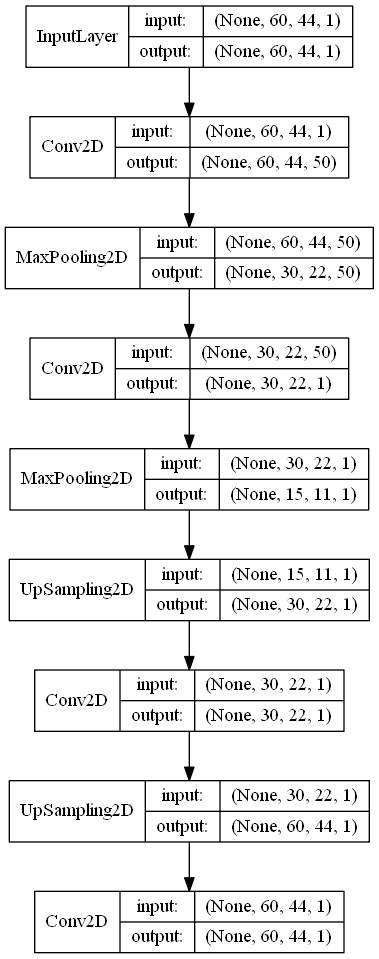

In [69]:
plot_model(autoencoder, show_shapes=True, show_layer_names=False)

In [113]:
autoencoder.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 60, 44, 1)         0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 60, 44, 1)         10        
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 30, 22, 1)         0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 30, 22, 1)         10        
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 15, 11, 1)         0         
_________________________________________________________________
up_sampling2d_28 (UpSampling (None, 30, 22, 1)         0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 30, 22, 1)         10 

In [114]:
autoencoder.fit(noisytrain, treino, epochs=40, batch_size=128, callbacks=[historia], validation_split = 0.1)

Train on 9527 samples, validate on 1059 samples
Epoch 1/40
9527/9527 [==============================] - 13s 1ms/step - loss: 0.0814 - mean_squared_error: 0.0814 - mean_absolute_error: 0.2347 - binary_crossentropy: 0.8049 - accuracy: 1.5944e-05 - val_loss: 0.0640 - val_mean_squared_error: 0.0640 - val_mean_absolute_error: 0.2028 - val_binary_crossentropy: 0.7615 - val_accuracy: 1.7884e-06
Epoch 2/40
9527/9527 [==============================] - 13s 1ms/step - loss: 0.0522 - mean_squared_error: 0.0522 - mean_absolute_error: 0.1801 - binary_crossentropy: 0.7347 - accuracy: 1.5944e-05 - val_loss: 0.0428 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1619 - val_binary_crossentropy: 0.7144 - val_accuracy: 1.7884e-06
Epoch 3/40
9527/9527 [==============================] - 13s 1ms/step - loss: 0.0381 - mean_squared_error: 0.0381 - mean_absolute_error: 0.1535 - binary_crossentropy: 0.7045 - accuracy: 1.6142e-05 - val_loss: 0.0348 - val_mean_squared_error: 0.0348 - val_mean_absolut

Epoch 25/40
9527/9527 [==============================] - 13s 1ms/step - loss: 0.0205 - mean_squared_error: 0.0205 - mean_absolute_error: 0.1077 - binary_crossentropy: 0.6687 - accuracy: 4.7950e-05 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1054 - val_binary_crossentropy: 0.6675 - val_accuracy: 5.0434e-05
Epoch 26/40
9527/9527 [==============================] - 13s 1ms/step - loss: 0.0192 - mean_squared_error: 0.0192 - mean_absolute_error: 0.1036 - binary_crossentropy: 0.6661 - accuracy: 4.8149e-05 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1013 - val_binary_crossentropy: 0.6650 - val_accuracy: 5.0791e-05
Epoch 27/40
9527/9527 [==============================] - 13s 1ms/step - loss: 0.0180 - mean_squared_error: 0.0180 - mean_absolute_error: 0.0997 - binary_crossentropy: 0.6636 - accuracy: 4.8149e-05 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.0974 - val_binary_crossentropy: 0.

### Predizendo

In [115]:
pred_train = autoencoder.predict(noisytrain) # in sample
pred_test = autoencoder.predict(noisytest) # out of sample

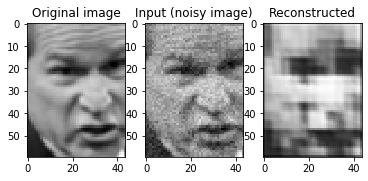

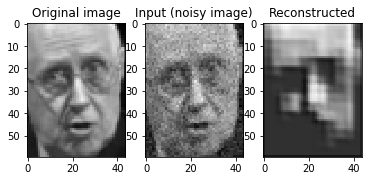

In [116]:
plot_compare(25, test, noisytest, pred_test) # out of sample prediction

plot_compare(15, train, noisytrain, pred_train) # in sample prediction - should be better

# Testando arquitetura 3

In [50]:
def make_autoencoder():
  # encoding
  inputs = Input(shape=(60, 44, 1)) 
  x = Conv2D(filters = 100, kernel_size = (3, 3), activation = 'relu', padding = 'same')(inputs) 
  x = MaxPooling2D(pool_size = 8, padding = 'same')(x)
  x = Conv2D(filters = 10, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x) 
  x = MaxPooling2D(pool_size = 8, padding = 'same')(x)
  x = Conv2D(filters = 10, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x) 

  # decoding
  x = UpSampling2D(size = (1, 11))(x)
  x = Conv2D(filters = 10, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')(x) 
  x = UpSampling2D(size = (3, 2))(x)
  x = Conv2D(filters = 1, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')(x) 
  x = UpSampling2D(size = (5, 2))(x)
  x = Conv2D(filters = 1, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')(x) 
  x = UpSampling2D(size = (4, 1))(x)
  x = Conv2D(filters = 1, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')(x) 

  # autoencoder compilation
  autoencoder = Model(inputs, x)
  autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = metricas)
  return autoencoder
autoencoder = make_autoencoder()
historia = History()

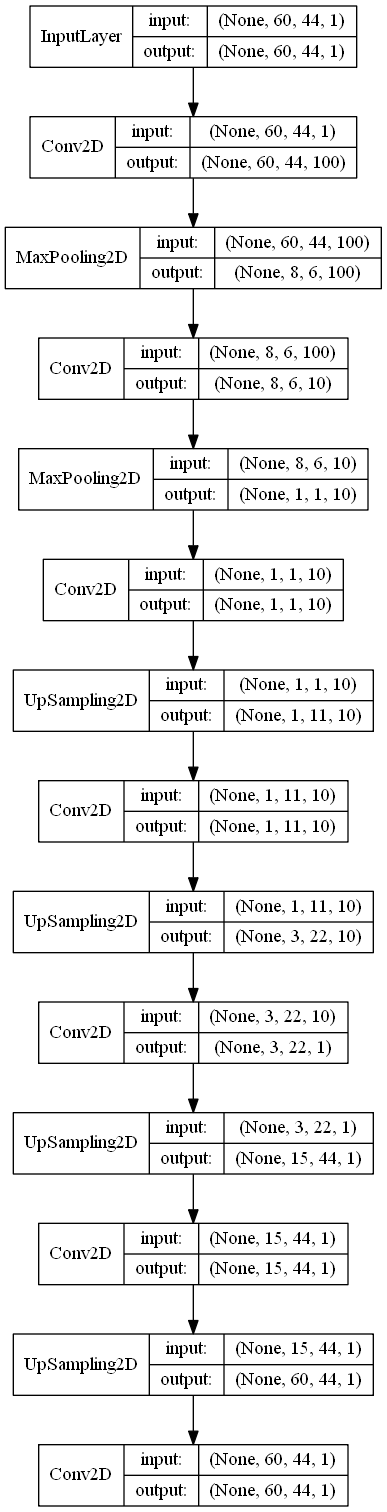

In [51]:
plot_model(autoencoder, show_shapes=True, show_layer_names=False)

In [52]:
autoencoder.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 60, 44, 1)         0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 60, 44, 100)       1000      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 8, 6, 100)         0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 8, 6, 10)          9010      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 1, 1, 10)          0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 1, 1, 10)          910       
_________________________________________________________________
up_sampling2d_53 (UpSampling (None, 1, 11, 10)         0  

In [53]:
autoencoder.fit(noisytrain, train, epochs=40, batch_size=128, callbacks=[historia], validation_split = 0.1)

Train on 9527 samples, validate on 1059 samples
Epoch 1/40
9527/9527 [==============================] - 84s 9ms/step - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.1511 - binary_crossentropy: 0.6971 - accuracy: 3.0336e-05 - val_loss: 0.0337 - val_mean_squared_error: 0.0337 - val_mean_absolute_error: 0.1479 - val_binary_crossentropy: 0.6956 - val_accuracy: 1.2877e-05
Epoch 2/40
9527/9527 [==============================] - 86s 9ms/step - loss: 0.0336 - mean_squared_error: 0.0336 - mean_absolute_error: 0.1480 - binary_crossentropy: 0.6952 - accuracy: 2.1351e-05 - val_loss: 0.0333 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1473 - val_binary_crossentropy: 0.6949 - val_accuracy: 1.4665e-05
Epoch 3/40
9527/9527 [==============================] - 87s 9ms/step - loss: 0.0332 - mean_squared_error: 0.0332 - mean_absolute_error: 0.1473 - binary_crossentropy: 0.6944 - accuracy: 1.9800e-05 - val_loss: 0.0329 - val_mean_squared_error: 0.0329 - val_mean_absolut

Epoch 25/40
9527/9527 [==============================] - 99s 10ms/step - loss: 0.0223 - mean_squared_error: 0.0223 - mean_absolute_error: 0.1159 - binary_crossentropy: 0.6722 - accuracy: 4.6399e-05 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1155 - val_binary_crossentropy: 0.6726 - val_accuracy: 4.3280e-05
Epoch 26/40
9527/9527 [==============================] - 95s 10ms/step - loss: 0.0221 - mean_squared_error: 0.0221 - mean_absolute_error: 0.1154 - binary_crossentropy: 0.6719 - accuracy: 4.6439e-05 - val_loss: 0.0222 - val_mean_squared_error: 0.0222 - val_mean_absolute_error: 0.1158 - val_binary_crossentropy: 0.6723 - val_accuracy: 4.3638e-05
Epoch 27/40
9527/9527 [==============================] - 84s 9ms/step - loss: 0.0220 - mean_squared_error: 0.0220 - mean_absolute_error: 0.1151 - binary_crossentropy: 0.6717 - accuracy: 4.6479e-05 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1152 - val_binary_crossentropy: 

In [54]:
pred_train = autoencoder.predict(noisytrain) # in sample
pred_test = autoencoder.predict(noisytest) # out of sample

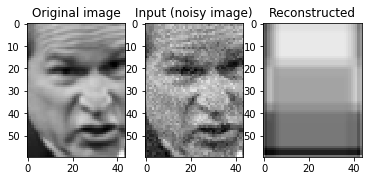

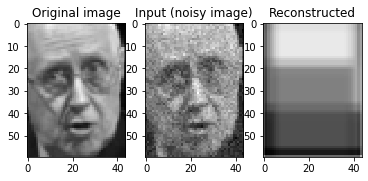

In [55]:
plot_compare(25, test, noisytest, pred_test) # out of sample prediction

plot_compare(15, train, noisytrain, pred_train) # in sample prediction - should be better

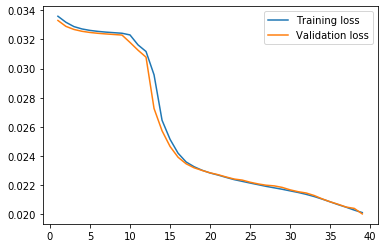

In [56]:
start = 1
finish = 40

y1 = historia.history['loss'][start:finish]
y2 = historia.history['val_loss'][start:finish]
x = range(start, finish)
sns.lineplot(x, y1, label = 'Training loss')
sns.lineplot(x, y2, label = 'Validation loss')

In [57]:
scipy.stats.describe(pred_train[0].flatten())

DescribeResult(nobs=2640, minmax=(0.26690403, 0.5220189), mean=0.420895, variance=0.0013943539, skewness=-1.354634165763855, kurtosis=2.9229977486340353)

In [58]:
mse_list_treino = np.zeros(len(pred_train))
for i in range(len(pred_train)):
    mse_list_treino[i] = np.mean((pred_train[i] - noisytrain[i])**2)
    
mse_list_teste = np.zeros(len(pred_test))
for i in range(len(pred_test)):
    mse_list_teste[i] = np.mean((pred_test[i] - noisytest[i])**2)


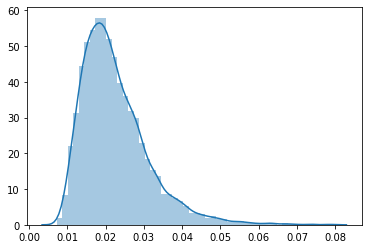

In [59]:
sns.distplot(mse_list_treino)

In [60]:
scipy.stats.describe(mse_list_treino)

DescribeResult(nobs=10586, minmax=(0.007303131000477538, 0.0790079973806023), mean=0.02247900200140864, variance=7.710910083159323e-05, skewness=1.4424816631817003, kurtosis=3.475059655647878)

In [61]:
scipy.stats.describe(mse_list_teste)

DescribeResult(nobs=2647, minmax=(0.007221214034618307, 0.076044120655133), mean=0.02247255804701987, variance=7.678092144525313e-05, skewness=1.2961753574645387, kurtosis=2.572182014603314)

## Testando arquitetura 4: 

In [46]:
def make_autoencoder():
  # encoding
  inputs = Input(shape=(60, 44, 1)) 
  x = Conv2D(filters = 100, kernel_size = (3, 3), activation = 'relu', padding = 'same')(inputs) 
  x = MaxPooling2D(pool_size = 4, padding = 'same')(x)
  x = Conv2D(filters = 10, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x) 

  # decoding
  x = UpSampling2D(size = (2, 2))(x)
  x = Conv2D(filters = 10, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')(x) 
  x = UpSampling2D(size = (2, 2))(x)
  x = Conv2D(filters = 1, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')(x) 

  # autoencoder compilation
  autoencoder = Model(inputs, x)
  autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = metricas)
  return autoencoder
autoencoder = make_autoencoder()
historia = History()

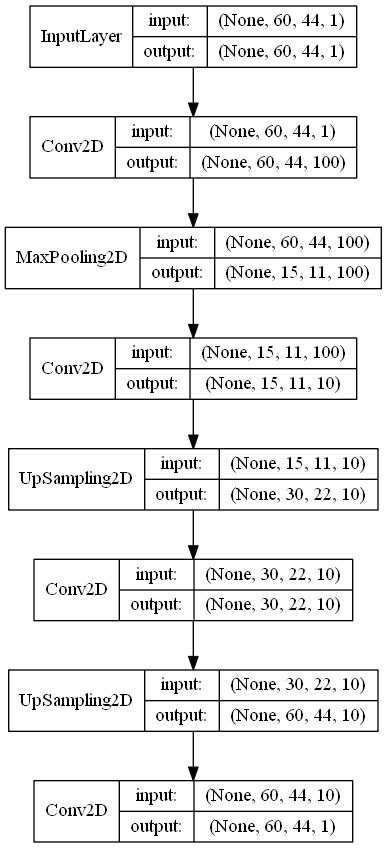

In [47]:
plot_model(autoencoder, show_shapes=True, show_layer_names=False)

In [48]:
autoencoder.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 60, 44, 1)         0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 60, 44, 100)       1000      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 15, 11, 100)       0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 15, 11, 10)        9010      
_________________________________________________________________
up_sampling2d_35 (UpSampling (None, 30, 22, 10)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 30, 22, 10)        910       
_________________________________________________________________
up_sampling2d_36 (UpSampling (None, 60, 44, 10)        0  

In [50]:
autoencoder.fit(noisytrain, train, epochs=40, batch_size=128, callbacks=[historia], validation_split = 0.1)

Train on 9527 samples, validate on 1059 samples
Epoch 1/40
9527/9527 [==============================] - 76s 8ms/step - loss: 0.0324 - mean_squared_error: 0.0324 - mean_absolute_error: 0.1414 - binary_crossentropy: 0.6940 - accuracy: 4.4093e-05 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.0978 - val_binary_crossentropy: 0.6594 - val_accuracy: 5.1149e-05
Epoch 2/40
9527/9527 [==============================] - 78s 8ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0746 - binary_crossentropy: 0.6466 - accuracy: 4.8705e-05 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0654 - val_binary_crossentropy: 0.6421 - val_accuracy: 5.1864e-05
Epoch 3/40
9527/9527 [==============================] - 78s 8ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0615 - binary_crossentropy: 0.6399 - accuracy: 4.8864e-05 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolut

Epoch 25/40
9527/9527 [==============================] - 79s 8ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0310 - binary_crossentropy: 0.6276 - accuracy: 4.8904e-05 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0307 - val_binary_crossentropy: 0.6277 - val_accuracy: 5.1864e-05
Epoch 26/40
9527/9527 [==============================] - 79s 8ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0308 - binary_crossentropy: 0.6275 - accuracy: 4.8904e-05 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0304 - val_binary_crossentropy: 0.6276 - val_accuracy: 5.1864e-05
Epoch 27/40
9527/9527 [==============================] - 80s 8ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0307 - binary_crossentropy: 0.6274 - accuracy: 4.8904e-05 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0306 - val_binary_crossentropy: 0.

### Predizendo

In [115]:
pred_train = autoencoder.predict(noisytrain) # in sample
pred_test = autoencoder.predict(noisytest) # out of sample

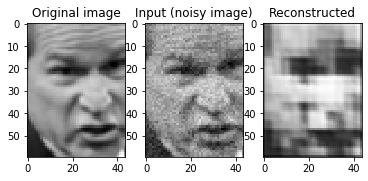

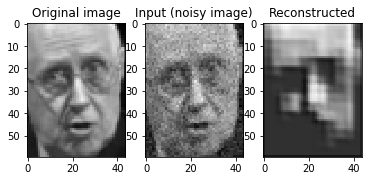

In [116]:
plot_compare(25, test, noisytest, pred_test) # out of sample prediction

plot_compare(15, train, noisytrain, pred_train) # in sample prediction - should be better